In [1]:
import matplotlib.pyplot as plt
import torch
import importlib
import json

In [2]:
torch.cuda.is_available()

True

In [3]:
MODEL_NAME = 'MoreDeeperCNN'
DATASET_NAME = 'DATASET_CNN'
TRAIN_PATH = f'../segments/{DATASET_NAME}/train_specs'
TEST_PATH = f'../segments/{DATASET_NAME}/train_specs'

In [4]:
def load_model_class(model_name):
    model_module = importlib.import_module(f"models.{model_name}.model")
    model_class = getattr(model_module, model_name)
    return model_class

In [5]:
with open(f"utils/{DATASET_NAME}/dataset_config.json") as f:
    dataset_config = json.load(f)

In [6]:
# load model

model_class = load_model_class(MODEL_NAME)
model = model_class(len(dataset_config['mappings']))

In [7]:
from torch.utils.data import Dataset
def wav_to_spec(audio_path):
    split = audio_path.split("/")[-3]
    audio = audio_path.replace("wav", "pt").replace(split, f"{split}_specs")
    return audio

class CachedAudioDataset(Dataset):
    def __init__(self, dataset_config, split="train"):
        self.samples = [s for s in dataset_config["samples"] if s["split"] == split]
        self.num_classes = len(dataset_config["mappings"])
        
        # Carica tutto in RAM
        self.cache = []
        for sample in self.samples:
            spec = torch.load(wav_to_spec(sample["file_path"]))  # spettrogramma
            label_tensor = torch.zeros(self.num_classes)
            for label in sample["labels"]:
                label_tensor[label] = 1.0
            self.cache.append((spec, label_tensor, sample["file_path"]))

    def __len__(self):
        return len(self.cache)

    def __getitem__(self, idx):
        return self.cache[idx]


In [8]:
from torch.utils.data import DataLoader

def get_dataloader(dataset_config, split="train", batch_size=100, shuffle=True):
    dataset = CachedAudioDataset(dataset_config=dataset_config, split=split)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [9]:
loader = get_dataloader(dataset_config, split="test", batch_size=1, shuffle=True)

In [10]:
# Ottieni un solo batch
input_tensor, label, file_path = next(iter(loader))  # batch_size = 1
input_tensor = input_tensor.squeeze(0)

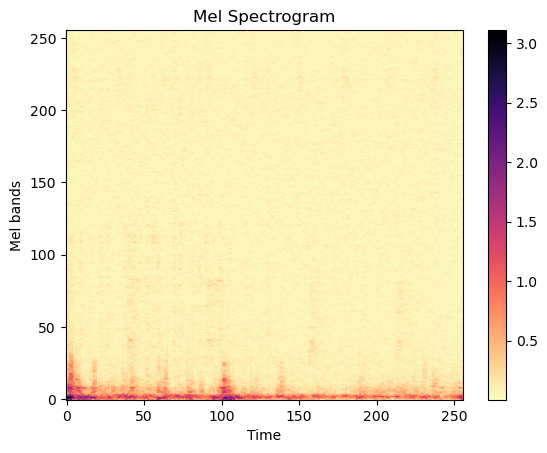

In [11]:
import matplotlib.pyplot as plt

plt.imshow(input_tensor.squeeze().numpy(), origin='lower', aspect='auto', cmap='magma_r')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Mel bands")
plt.show()


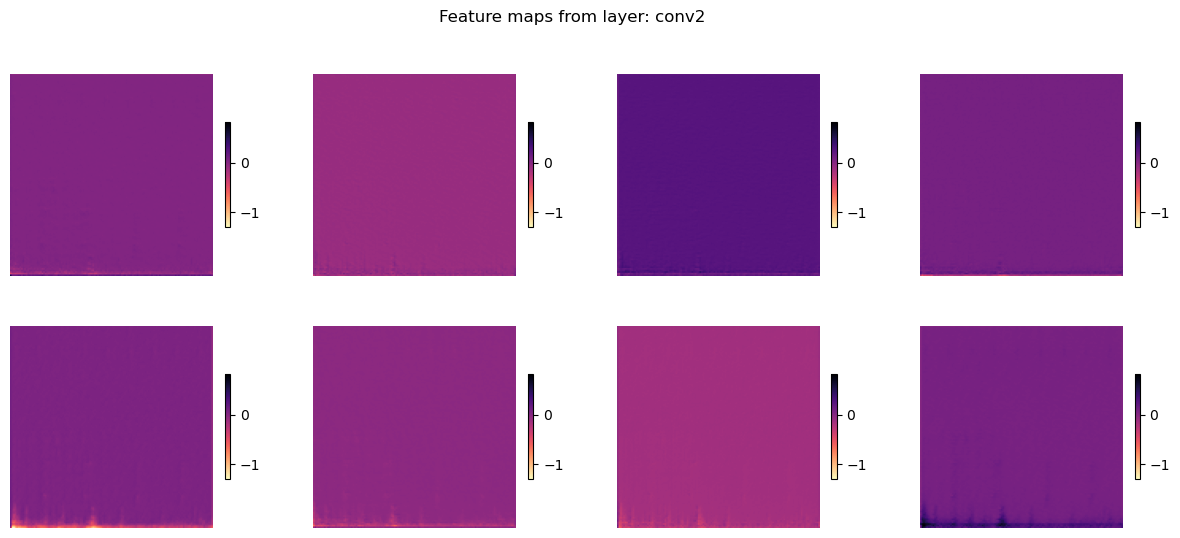

In [12]:
def visualize_activations(model, input_tensor, layer_name='conv1'):
    model.eval()
    activations = []

    def hook_fn(module, input, output):
        activations.append(output)

    # Registrare un hook sul layer desiderato
    layer = dict([*model.named_modules()])[layer_name]
    hook = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        model(input_tensor.unsqueeze(0).to(next(model.parameters()).device))  # [1, C, H, W]

    hook.remove()

    act = activations[0].squeeze().cpu()  # shape [C, H, W]
    n_maps = min(8, act.shape[0])  # mostra massimo 8 canali

    # Calcola il minimo e il massimo globali
    min_val = torch.min(act[:n_maps])
    max_val = torch.max(act[:n_maps])

    fig, axs = plt.subplots(2, 4, figsize=(15, 6))  # Griglia 2x4 (4x2 trasposto)
    for i in range(n_maps):
        row = i // 4
        col = i % 4
        im = axs[row, col].imshow(act[i], origin='lower', cmap='magma_r', vmin=min_val, vmax=max_val) #imposta i limiti della colorbar
        axs[row, col].axis('off')
        fig.colorbar(im, ax=axs[row, col], shrink=0.5)  # Aggiungi colorbar

    # Se ci sono meno di 8 mappe, nascondi gli assi vuoti
    for i in range(n_maps, 8):
        row = i // 4
        col = i % 4
        axs[row, col].axis('off')
        axs[row, col].set_visible(False)

    plt.suptitle(f"Feature maps from layer: {layer_name}")
    plt.show()

visualize_activations(model, input_tensor, layer_name='conv2')

In [32]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader
import tempfile
import os
import numpy as np

def create_model_pdf_report(model, input_tensors, pdf_path="model_report.pdf", device='cpu'):
    """
    Genera un report PDF del modello con la struttura e le visualizzazioni dei layer
    per una lista di input_tensor (batch separati).
    """
    model.to(device)

    # PDF setup
    c = canvas.Canvas(pdf_path, pagesize=A4)
    width, height = A4
    margin = 50
    y = height - margin

    # 1. Model Structure
    c.setFont("Helvetica-Bold", 16)
    c.drawString(margin, y, "Model Structure")
    y -= 20

    c.setFont("Courier", 8)
    y = height - 100
    for line in str(model).split('\n'):
        if y < 72:
            c.showPage()
            y = height - 72
            c.setFont("Courier", 8)
        c.drawString(72, y, line)
        y -= 10
    c.showPage()

    # Setup hooks
    def get_activation_hook(layer_name):
        def hook(model, input, output):
            activation[layer_name] = output.detach().cpu()
        return hook

    handles = []
    for name, layer in model.named_modules():
        if isinstance(layer, (nn.Conv2d, nn.ReLU, nn.MaxPool2d)):
            handles.append(layer.register_forward_hook(get_activation_hook(name)))

    # For each input tensor (max 3)
    with tempfile.TemporaryDirectory() as tmpdir:
        for idx, input_tensor in enumerate(input_tensors[:3]):
            activation = {}
            input_tensor = input_tensor.to(device).unsqueeze(0)

            # Spectrogram visualization
            spec_np = input_tensor.squeeze().cpu().numpy()
            plt.figure(figsize=(8, 3))
            plt.imshow(spec_np, aspect='auto', origin='lower', cmap='magma')
            plt.title(f"Input Spectrogram #{idx + 1}")
            plt.colorbar()
            spec_path = os.path.join(tmpdir, f"spectrogram_{idx}.png")
            plt.savefig(spec_path)
            plt.close()

            _ = model(input_tensor)

            # Add Spectrogram to PDF
            y = height - margin
            if y < 150:
                c.showPage()
                y = height - margin
            c.setFont("Helvetica-Bold", 12)
            c.drawString(margin, y, f"Input Spectrogram #{idx + 1}")
            y -= 20
            c.drawImage(ImageReader(spec_path), margin, y - 120, width=400, height=100)
            y -= 140

            # Feature Maps
            for layer_name, feature_map in activation.items():
                if feature_map.dim() == 4:  # Conv2D output shape: (B, C, H, W)
                    fmap = feature_map[0]  # First in batch
                    num_channels = min(4, fmap.shape[0])
                    fig, axs = plt.subplots(1, num_channels, figsize=(12, 3))
                    axs = axs if isinstance(axs, np.ndarray) else [axs]
                    for i in range(num_channels):
                        axs[i].imshow(fmap[i], cmap='viridis', aspect='auto')
                        axs[i].axis('off')
                    fig.suptitle(f"Layer: {layer_name}")
                    fmap_path = os.path.join(tmpdir, f"{layer_name}_input{idx}.png")
                    plt.savefig(fmap_path)
                    plt.close()

                    if y < 150:
                        c.showPage()
                        y = height - margin
                    c.drawImage(ImageReader(fmap_path), margin, y - 120, width=400, height=100)
                    y -= 130

    for h in handles:
        h.remove()

    c.save()
    print(f"📄 PDF salvato in: {pdf_path}")


In [33]:
# Esempio uso
dataloader = get_dataloader(dataset_config, split="test", batch_size=1)
input_tensors = []
for idx, (spec, _, _) in enumerate(dataloader):
    input_tensors.append(spec.squeeze(0))
    if len(input_tensors) == 3:
        break

create_model_pdf_report(model, input_tensors, pdf_path="model_layer_report.pdf", device='cuda')


📄 PDF salvato in: model_layer_report.pdf
